In [1]:
#imports
import os
import h5py
import scipy
import math
from sklearn import metrics
import numpy as np
import pandas as pd 
from IPython.display import Audio
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.pyplot import imread
import librosa
import librosa.display
!pip install natsort
import natsort
from scipy import signal
from scipy.io import wavfile
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops


%matplotlib inline
np.random.seed(1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#connecting to drive
from google.colab import drive
drive.mount('/content/gdrive')
data_path = '/content/gdrive/MyDrive/PATTERN_3/crema'

Mounted at /content/gdrive


In [3]:
def noise(data, random=False, rate=0.05, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

In [4]:
def zero_crossingRate(sound):
  return librosa.feature.zero_crossing_rate(y=sound)

In [ ]:
def MFCCs(sound):
  return librosa.feature.mfcc(y=sound)

In [5]:
def energy(sound):
   return librosa.feature.rms(y=sound)

In [6]:
def load_data() :
    labels = []
    # mel_spectograms=[]
    features=[]

    for file in natsort.natsorted(os.listdir(data_path)):
        fileName = file.split("_")
        label=fileName[2]
        path = os.path.join(data_path , file)
        sound, sr = librosa.load(path, duration=3.5, sr=None)
        sound_noise = noise(sound, random = True)
        sound_pitch = pitch(sound, sr, pitch_factor=0.5, random=True)
        if librosa.get_duration(y = sound) < 3.5:
          sound = np.pad(sound,(math.ceil((77175-sound.shape[0])/2),math.floor((77175-sound.shape[0])/2)), 'constant')
          sound_noise = np.pad(sound_noise,(math.ceil((77175-sound_noise.shape[0])/2),math.floor((77175-sound_noise.shape[0])/2)), 'constant')
          sound_pitch = np.pad(sound_pitch,(math.ceil((77175-sound_pitch.shape[0])/2),math.floor((77175-sound_pitch.shape[0])/2)), 'constant')
       
        
        
        features.append(np.append(zero_crossingRate(sound), energy(sound)))
        features.append(np.append(zero_crossingRate(sound_noise), energy(sound_noise)))
        features.append(np.append(zero_crossingRate(sound_pitch), energy(sound_pitch)))
        
        labels.extend([label]*3)
        
    return features, labels


In [7]:
features, labels = load_data()

In [8]:
def get_splitted_data(data, labels):
    # we startify the data corresponding to label as the should be dsitributed on all the splitted data
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.3, random_state=0,stratify = labels)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.05,random_state=0, stratify = y_train)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), np.array(X_val), np.array(y_val)

In [9]:
x_train_1d, y_train_1d, X_test_1d, y_test_1d, X_val_1d, y_val_1d =  get_splitted_data(features, labels.copy())

In [10]:
x_train_1d = x_train_1d[:, :, np.newaxis]
x_test_1d = X_test_1d[:, :, np.newaxis]
x_val_1d = X_val_1d[:, :, np.newaxis]
print(x_train_1d.shape)

(14882, 302, 1)


In [11]:
# labels ['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']
LABELS = {'ANG' : np.array([1, 0, 0, 0, 0, 0]),
          'DIS' : np.array([0, 1, 0, 0, 0, 0]),
          'FEA' : np.array([0, 0, 1, 0, 0, 0]),
          'HAP' : np.array([0, 0, 0, 1, 0, 0]),
          'NEU' : np.array([0, 0, 0, 0, 1, 0]),
          'SAD' : np.array([0, 0, 0, 0, 0, 1])
        }

In [12]:
y_train_1d = np.array([LABELS[letter] for letter in y_train_1d])
y_test_1d = np.array([LABELS[letter] for letter in y_test_1d])
y_val_1d = np.array([LABELS[letter] for letter in y_val_1d])
print(y_train_1d.shape)
print(y_test_1d.shape)
print(y_val_1d.shape)

(14882, 6)
(6714, 6)
(784, 6)


In [13]:
#1D
x_train_1d = (x_train_1d - np.min(x_train_1d)) / (np.max(x_train_1d) - np.min(x_train_1d))
x_test_1d = (x_test_1d - np.min(x_test_1d)) / (np.max(x_test_1d) - np.min(x_test_1d))
x_val_1d = (x_val_1d - np.min(x_val_1d)) / (np.max(x_val_1d) - np.min(x_val_1d))

In [14]:
def create_conv_model_3_1d(input_shape):
  input_img = tf.keras.Input(shape=input_shape)
  Z0 = tfl.Conv1D(64, 3, activation='relu')(input_img)
  P1 = tfl.MaxPooling1D(pool_size=2)(Z0)
  Z2 = tfl.Conv1D(128, 3, activation='relu')(P1)
  P2 = tfl.MaxPooling1D(pool_size=2)(Z2)
  Z3 = tfl.Conv1D(256, 3, activation='relu')(P2)
  P3 = tfl.MaxPooling1D(pool_size=2)(Z3)
  F = tfl.Flatten()(P3)
  FC1 = tfl.Dense(256, activation='relu')(F)
  FC2 = tfl.Dropout(0.5)(FC1)
  outputs = tfl.Dense(6, activation='softmax')(FC2)
    
    
  # YOUR CODE ENDS HERE
  model = tf.keras.Model(inputs=input_img, outputs=outputs)
  return model

In [15]:
conv_model_3_1d = create_conv_model_3_1d((302, 1))
conv_model_3_1d.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model_3_1d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 302, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 300, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 74, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 72, 256)           98560 

In [16]:
train_dataset_3_1d = tf.data.Dataset.from_tensor_slices((x_train_1d, y_train_1d)).batch(64)
test_dataset_3_1d = tf.data.Dataset.from_tensor_slices((x_val_1d, y_val_1d)).batch(64)
checkpoint_filepath3 = '/content/gdrive/MyDrive/Test/model_3'
model_checkpoint_callback3 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath3,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)
history = conv_model_3_1d.fit(train_dataset_3_1d, epochs=200, validation_data=test_dataset_3_1d, callbacks=[model_checkpoint_callback3])

Epoch 1/200
233/233 [==============================] - 16s 15ms/step - loss: 1.5290 - accuracy: 0.3639 - val_loss: 1.4715 - val_accuracy: 0.4120
Epoch 2/200
233/233 [==============================] - 2s 8ms/step - loss: 1.4206 - accuracy: 0.4297 - val_loss: 1.4006 - val_accuracy: 0.4349
Epoch 3/200
233/233 [==============================] - 2s 7ms/step - loss: 1.3848 - accuracy: 0.4426 - val_loss: 1.3810 - val_accuracy: 0.4439
Epoch 4/200
233/233 [==============================] - 2s 7ms/step - loss: 1.3597 - accuracy: 0.4502 - val_loss: 1.3496 - val_accuracy: 0.4566
Epoch 5/200
233/233 [==============================] - 2s 7ms/step - loss: 1.3301 - accuracy: 0.4674 - val_loss: 1.3269 - val_accuracy: 0.4732
Epoch 6/200
233/233 [==============================] - 2s 7ms/step - loss: 1.3112 - accuracy: 0.4800 - val_loss: 1.3054 - val_accuracy: 0.4911
Epoch 7/200
233/233 [==============================] - 1s 6ms/step - loss: 1.2864 - accuracy: 0.4903 - val_loss: 1.2863 - val_accuracy: 0.47

In [17]:
test_dataset3 = tf.data.Dataset.from_tensor_slices((x_test_1d, y_test_1d)).batch(64)
conv_model_3_1d.load_weights(checkpoint_filepath3)
conv_model_3_1d.evaluate(test_dataset3)

105/105 [==============================] - 1s 5ms/step - loss: 2.1480 - accuracy: 0.7043


[2.148045063018799, 0.7043491005897522]

105/105 [==============================] - 1s 5ms/step
 Classification_for model 1 : 

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1147
           1       0.69      0.67      0.68      1149
           2       0.65      0.61      0.63      1149
           3       0.69      0.68      0.68      1145
           4       0.71      0.72      0.72       979
           5       0.69      0.72      0.70      1145

   micro avg       0.70      0.70      0.70      6714
   macro avg       0.70      0.70      0.70      6714
weighted avg       0.70      0.70      0.70      6714
 samples avg       0.70      0.70      0.70      6714

Confusion matrix for label : SAD


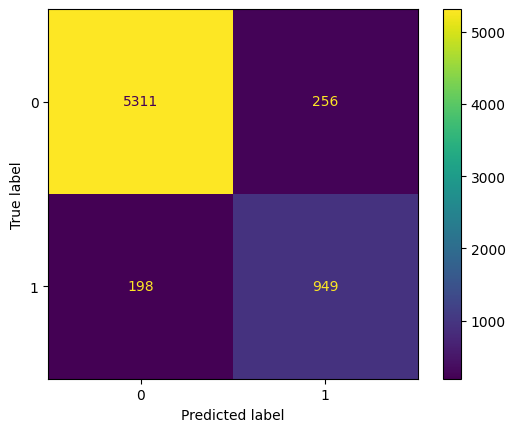

Confusion matrix for label : ANG


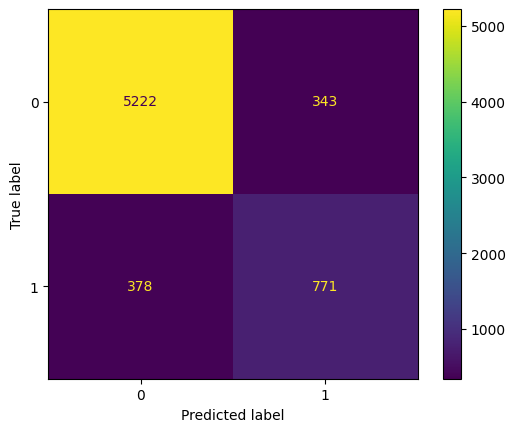

Confusion matrix for label : DIS


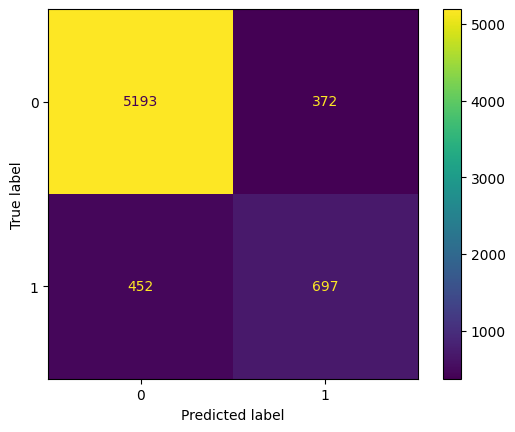

Confusion matrix for label : FEA


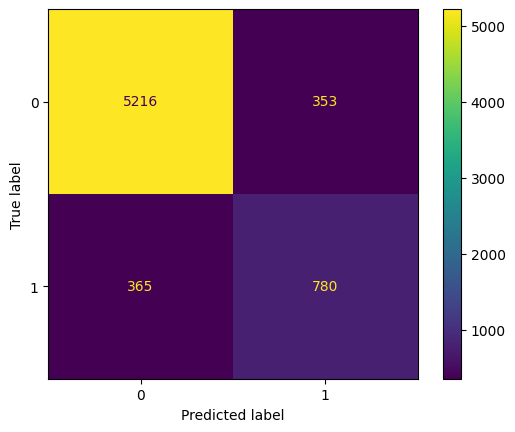

Confusion matrix for label : HAP


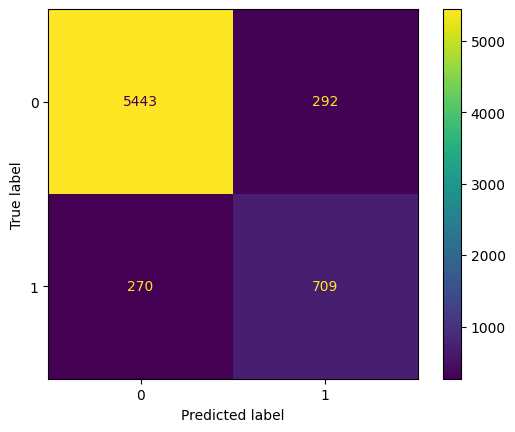

Confusion matrix for label : NEU


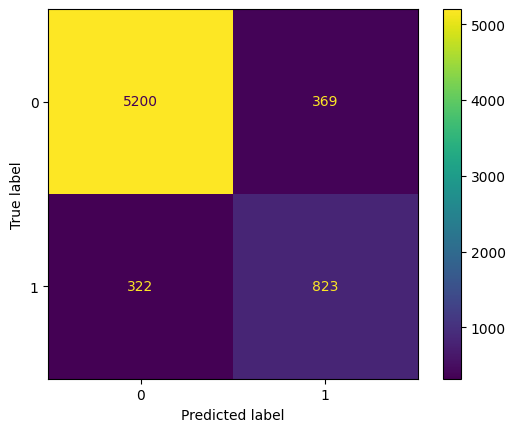

In [18]:
evaL_labels_1d = conv_model_3_1d.predict(test_dataset3)

predicted_labels_1d = []
for i  in evaL_labels_1d:
    arr1 = np.zeros(6)
    arr1[np.argmax(i)] = 1
    predicted_labels_1d.append(arr1)


predicted_labels_1d = np.asarray(predicted_labels_1d)

confusion_1d={}

emotions_labels = ["SAD","ANG", "DIS", "FEA", "HAP", "NEU"]

for label in range(len(emotions_labels)):
    true_label_1d = y_test_1d[:, label]
    pred_label_1d = predicted_labels_1d[:, label]
    confusion_1d[emotions_labels[label]] = metrics.confusion_matrix(y_pred=pred_label_1d, y_true=true_label_1d)

print(" Classification_for model 1 : \n")

print(classification_report(y_test_1d , predicted_labels_1d))
for label, matrix in confusion_1d.items():
    print("Confusion matrix for label :",label)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    plt.show()

In [19]:
def create_conv_model2_1d(input_shape):
  input_img = tf.keras.Input(shape=input_shape)
  Z0 = tfl.Conv1D(256, 5, activation='relu', padding="same", strides=1)(input_img)
  Z1 = tfl.Conv1D(128, 5, activation='relu', padding="same", strides=1)(Z0)
  del(Z0)
  P1 = tfl.MaxPool1D(pool_size=(5), strides=(2), padding='same')(Z1)
  del(Z1)
  D0 = tfl.Dropout(0.3)(P1)
  del(P1)
  Z2 = tfl.Conv1D(128, 5, activation='relu', padding="same", strides=1)(D0)
  del(D0)
  P2 = tfl.MaxPool1D(pool_size=(5), strides=(2), padding='same')(Z2)
  del(Z2)
  D1 = tfl.Dropout(0.3)(P2)
  del(P2)
  Z3 = tfl.Conv1D(64, 5, activation='relu', padding="same", strides=1)(D1)
  del(D1)
  P3 = tfl.MaxPool1D(pool_size=(5), strides=(2), padding='same')(Z3)
  del(Z3)
  F = tfl.Flatten()(P3)
  del(P3)
  FC1 = tfl.Dense(1000, activation='relu')(F)
  del(F)
  D0 = tfl.Dropout(0.5)(FC1)
  del(FC1)
  FC2 = tfl.Dense(100, activation='relu')(D0)
  del(D0)
  outputs = tfl.Dense(6, activation='softmax')(FC2)
  del(FC2)
    
    
  # YOUR CODE ENDS HERE
  model = tf.keras.Model(inputs=input_img, outputs=outputs)
  return model

In [20]:
conv_model2_1d = create_conv_model2_1d((302, 1))
opt2 = tf.keras.optimizers.Adam(learning_rate=0.0001)
conv_model2_1d.compile(optimizer=opt2,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model2_1d.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 302, 1)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 302, 256)          1536      
                                                                 
 conv1d_4 (Conv1D)           (None, 302, 128)          163968    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 151, 128)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 151, 128)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 151, 128)          82048     
                                                           

In [21]:
train_dataset2_1d = tf.data.Dataset.from_tensor_slices((x_train_1d, y_train_1d)).batch(64)
test_dataset2_1d = tf.data.Dataset.from_tensor_slices((x_val_1d, y_val_1d)).batch(64)
checkpoint_filepath_model2 = '/content/gdrive/MyDrive/Test/model_2'
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath_model2,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)
history = conv_model2_1d.fit(train_dataset2_1d, epochs=200, validation_data=test_dataset2_1d, callbacks=[model_checkpoint_callback2])

Epoch 1/200
233/233 [==============================] - 8s 17ms/step - loss: 1.5997 - accuracy: 0.3233 - val_loss: 1.5159 - val_accuracy: 0.3622
Epoch 2/200
233/233 [==============================] - 4s 16ms/step - loss: 1.4670 - accuracy: 0.4006 - val_loss: 1.4621 - val_accuracy: 0.4107
Epoch 3/200
233/233 [==============================] - 4s 16ms/step - loss: 1.4299 - accuracy: 0.4185 - val_loss: 1.4346 - val_accuracy: 0.4286
Epoch 4/200
233/233 [==============================] - 4s 15ms/step - loss: 1.4131 - accuracy: 0.4280 - val_loss: 1.4219 - val_accuracy: 0.4439
Epoch 5/200
233/233 [==============================] - 3s 15ms/step - loss: 1.4020 - accuracy: 0.4284 - val_loss: 1.4101 - val_accuracy: 0.4413
Epoch 6/200
233/233 [==============================] - 4s 16ms/step - loss: 1.3953 - accuracy: 0.4355 - val_loss: 1.4007 - val_accuracy: 0.4439
Epoch 7/200
233/233 [==============================] - 4s 16ms/step - loss: 1.3859 - accuracy: 0.4418 - val_loss: 1.3917 - val_accuracy:

In [22]:
test_dataset2 = tf.data.Dataset.from_tensor_slices((x_test_1d, y_test_1d)).batch(64)
conv_model2_1d.load_weights(checkpoint_filepath_model2)
conv_model2_1d.evaluate(test_dataset2)

105/105 [==============================] - 1s 8ms/step - loss: 1.2114 - accuracy: 0.7271


[1.2114351987838745, 0.7271373271942139]

105/105 [==============================] - 1s 5ms/step
 Classification_for model 1 : 

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1147
           1       0.71      0.69      0.70      1149
           2       0.66      0.64      0.65      1149
           3       0.74      0.69      0.71      1145
           4       0.73      0.77      0.75       979
           5       0.72      0.75      0.73      1145

   micro avg       0.73      0.73      0.73      6714
   macro avg       0.73      0.73      0.73      6714
weighted avg       0.73      0.73      0.73      6714
 samples avg       0.73      0.73      0.73      6714

Confusion matrix for label : SAD


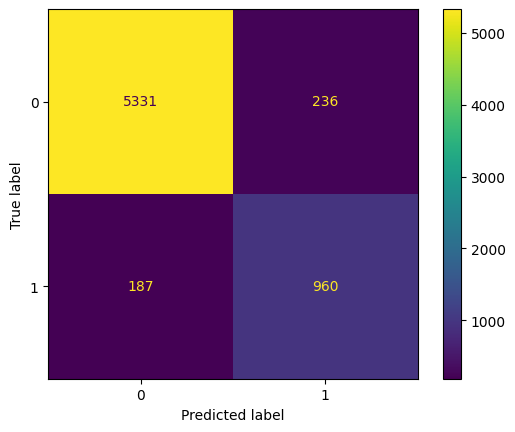

Confusion matrix for label : ANG


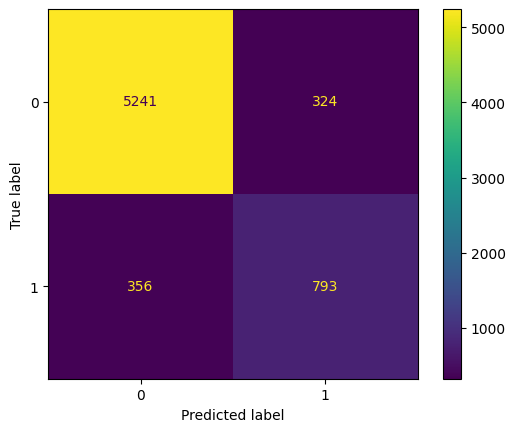

Confusion matrix for label : DIS


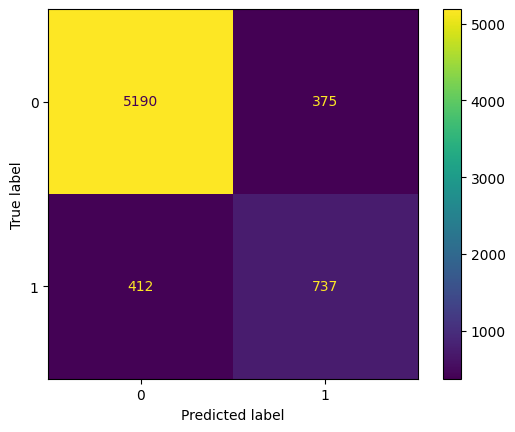

Confusion matrix for label : FEA


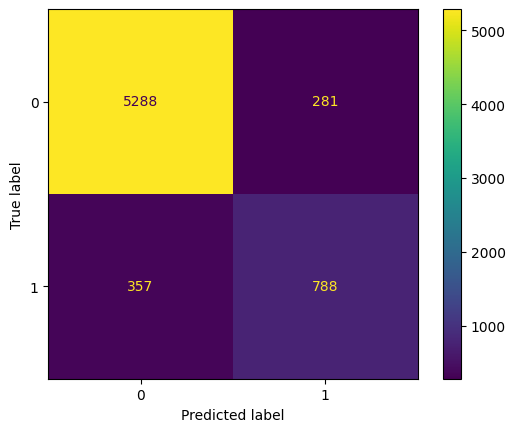

Confusion matrix for label : HAP


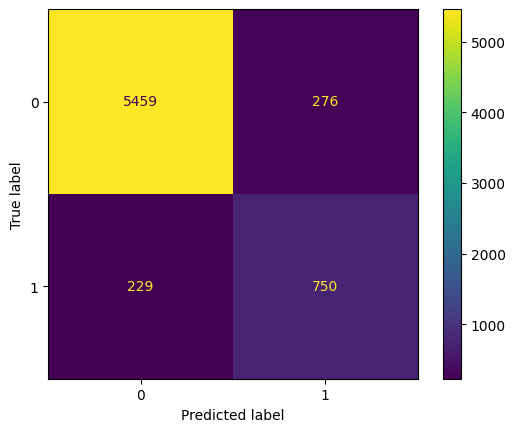

Confusion matrix for label : NEU


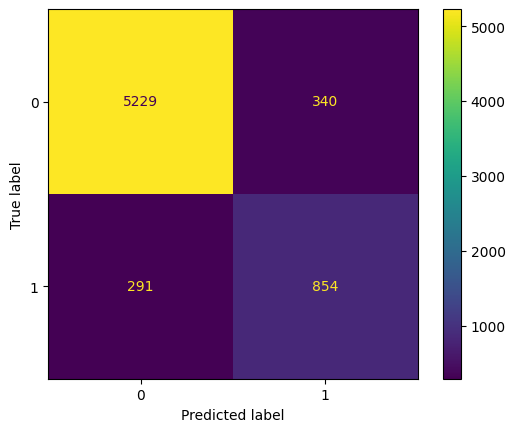

In [23]:
evaL_labels_1d = conv_model2_1d.predict(test_dataset2)

predicted_labels_1d = []
for i  in evaL_labels_1d:
    arr1 = np.zeros(6)
    arr1[np.argmax(i)] = 1
    predicted_labels_1d.append(arr1)


predicted_labels_1d = np.asarray(predicted_labels_1d)

confusion_1d={}

emotions_labels = ["SAD","ANG", "DIS", "FEA", "HAP", "NEU"]

for label in range(len(emotions_labels)):
    true_label_1d = y_test_1d[:, label]
    pred_label_1d = predicted_labels_1d[:, label]
    confusion_1d[emotions_labels[label]] = metrics.confusion_matrix(y_pred=pred_label_1d, y_true=true_label_1d)

print(" Classification_for model 1 : \n")

print(classification_report(y_test_1d , predicted_labels_1d))
for label, matrix in confusion_1d.items():
    print("Confusion matrix for label :",label)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    plt.show()